In [ ]:
pip install tensorflow transformers pandas numpy scikit-learn keras

In [ ]:
import os

# Install tf-keras
!pip install tf-keras

# Set TF_USE_LEGACY_KERAS environment variable
os.environ['TF_USE_LEGACY_KERAS'] = '1'


In [ ]:
import tensorflow as tf
import pandas as pd
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Change the name of the train file and test file
df = pd.read_csv('SMOTE Train Part 2 MESocSentiment.csv')
df2 = pd.read_csv('Test Part 2 Ground Truth.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Tweets           10863 non-null  object
 1   Sentiment (All)  10863 non-null  object
dtypes: object(2)
memory usage: 169.9+ KB


In [ ]:
df.head()

,Tweets,Sentiment (All)
0,dost karde bamszlk g kutluyoruz happy malaysia...,POSITIVE
1,malaysia face vietnam group b aff cup,NEUTRAL
2,whitebrowed crake poliolimnas cinereus baram w...,NEUTRAL
3,burmese pool taiping perak malaysia vivo x pro...,NEUTRAL
4,no comments penang malayasia,NEUTRAL


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Tweets                      2000 non-null   object
 1   Sentiment (MESocSentiment)  2000 non-null   object
 2   Sentiment (Manual)          2000 non-null   object
dtypes: object(3)
memory usage: 47.0+ KB


In [ ]:
df2.head()

,Tweets,Sentiment (MESocSentiment),Sentiment (Manual)
0,new post pocketimes youtube abang,NEUTRAL,NEUTRAL
1,merdeka motherfuckers,NEUTRAL,NEGATIVE
2,waiting bunga api kalau ada hahahah,NEUTRAL,NEUTRAL
3,random pics places kl took using ig filters se...,NEUTRAL,POSITIVE
4,kim pangon malaysia try new players chiangmai,NEUTRAL,NEUTRAL


In [ ]:
df2.drop(['Sentiment (MESocSentiment)'], axis = 1, inplace = True)
df2.head(100)

,Tweets,Sentiment (Manual)
0,new post pocketimes youtube abang,NEUTRAL
1,merdeka motherfuckers,NEGATIVE
2,waiting bunga api kalau ada hahahah,NEUTRAL
3,random pics places kl took using ig filters se...,POSITIVE
4,kim pangon malaysia try new players chiangmai,NEUTRAL
...,...,...
95,kahwin siam kahwin aggregate,NEUTRAL
96,kitar teliti ventures east roadone tyres,NEUTRAL
97,mano polking admit gol gol perlawanan ikut spe...,NEUTRAL
98,hiring data analyst intern lumpur,NEUTRAL


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Tweets              2000 non-null   object
 1   Sentiment (Manual)  2000 non-null   object
dtypes: object(2)
memory usage: 31.4+ KB


In [ ]:
#Text length distribution train set
df['sent_len'] = df['Tweets'].apply(lambda x: len(x.split(" ")))
max_seq_len_train = np.round(df['sent_len'].mean() + 2 * df['sent_len'].std()).astype(int)
max_seq_len_train

27

In [ ]:
#Text length distribution test set
df2['sent_len'] = df2['Tweets'].apply(lambda x: len(x.split(" ")))
max_seq_len_test = np.round(df2['sent_len'].mean() + 2 * df2['sent_len'].std()).astype(int)
max_seq_len_test

25

In [ ]:
# Create a new variable to hold the highest max_seq_len value
highest_max_seq_len = max(max_seq_len_train, max_seq_len_test)

print("The highest value of max_seq_len is:", highest_max_seq_len)

The highest value of max_seq_len is: 27


In [ ]:
# Load the pre-trained multilingual BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
#attention mask untuk train set
input_sequences_train = []
# The attention mask is an optional argument used when batching sequences together.
# The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
attention_masks_train = []

for text in df['Tweets']:
    sequence_dict = tokenizer.encode_plus(text, max_length=highest_max_seq_len, pad_to_max_length=True)
    input_ids = sequence_dict['input_ids']
    att_mask = sequence_dict['attention_mask']

    input_sequences_train.append(input_ids)
    attention_masks_train.append(att_mask)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
df['input_sequences_train'] =  input_sequences_train
df['attention_masks_train'] = attention_masks_train
df.head()

,Tweets,Sentiment (All),sent_len,input_sequences_train,attention_masks_train
0,dost karde bamszlk g kutluyoruz happy malaysia...,POSITIVE,11,"[101, 10398, 10123, 25085, 10253, 15688, 12387...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,malaysia face vietnam group b aff cup,NEUTRAL,7,"[101, 30785, 12682, 10280, 13295, 13772, 34247...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."
2,whitebrowed crake poliolimnas cinereus baram w...,NEUTRAL,10,"[101, 15263, 20923, 48854, 171, 15793, 10112, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,burmese pool taiping perak malaysia vivo x pro...,NEUTRAL,10,"[101, 11499, 100087, 10112, 34183, 25943, 1023...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,no comments penang malayasia,NEUTRAL,4,"[101, 10192, 61565, 39465, 10376, 30785, 62231...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#attention mask untuk test set
input_sequences_test = []
# The attention mask is an optional argument used when batching sequences together.
# The attention mask is a binary tensor indicating the position of the padded indices so that the model does not attend to them.
attention_masks_test = []

for text in df2['Tweets']:
    sequence_dict = tokenizer.encode_plus(text, max_length=highest_max_seq_len, pad_to_max_length=True)
    input_ids = sequence_dict['input_ids']
    att_mask = sequence_dict['attention_mask']

    input_sequences_test.append(input_ids)
    attention_masks_test.append(att_mask)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2760: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
df2['input_sequences_test'] =  input_sequences_test
df2['attention_masks_test'] = attention_masks_test
df2.head()

,Tweets,Sentiment (Manual),sent_len,input_sequences_test,attention_masks_test
0,new post pocketimes youtube abang,NEUTRAL,5,"[101, 10751, 11841, 32398, 13650, 73787, 53918...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
1,merdeka motherfuckers,NEGATIVE,2,"[101, 13697, 101916, 15293, 20758, 19153, 1010...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,waiting bunga api kalau ada hahahah,NEUTRAL,6,"[101, 62052, 60770, 35073, 84844, 10138, 15290...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, ..."
3,random pics places kl took using ig filters se...,POSITIVE,12,"[101, 61952, 24109, 13331, 19261, 83617, 12149...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,kim pangon malaysia try new players chiangmai,NEUTRAL,7,"[101, 38516, 40452, 10263, 30785, 12682, 10280...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ..."


In [ ]:
Y_train = pd.get_dummies(df['Sentiment (All)']).values
print('Shape of label tensor:', Y_train.shape)

Shape of label tensor: (10863, 3)


In [ ]:
Y_test = pd.get_dummies(df2['Sentiment (Manual)']).values
print('Shape of label tensor:', Y_test.shape)

Shape of label tensor: (2000, 3)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10863 entries, 0 to 10862
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tweets                 10863 non-null  object
 1   Sentiment (All)        10863 non-null  object
 2   sent_len               10863 non-null  int64 
 3   input_sequences_train  10863 non-null  object
 4   attention_masks_train  10863 non-null  object
dtypes: int64(1), object(4)
memory usage: 424.5+ KB


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Tweets                2000 non-null   object
 1   Sentiment (Manual)    2000 non-null   object
 2   sent_len              2000 non-null   int64 
 3   input_sequences_test  2000 non-null   object
 4   attention_masks_test  2000 non-null   object
dtypes: int64(1), object(4)
memory usage: 78.2+ KB


In [ ]:
#input sequences, attention mask, and sentiment (All)--sentiment labels
X_train = df['input_sequences_train'].tolist()
X_train = tf.constant(X_train)
Y_train = tf.constant(Y_train)
att_masks_train = df['attention_masks_train'].tolist()
att_masks_train = tf.constant(att_masks_train)


X_test = df2['input_sequences_test'].tolist()
X_test = tf.constant(X_test)
Y_test = tf.constant(Y_test)
att_masks_test = df2['attention_masks_test'].tolist()
att_masks_test = tf.constant(att_masks_test)

In [ ]:
print(f'Train | X shape: {X_train.shape}, att_mask shape: {att_masks_train.shape}, y shape: {Y_train.shape}')
print(f'Test | X shape: {X_test.shape}, att_mask shape: {att_masks_test.shape}, y shape: {Y_test.shape}')

Train | X shape: (10863, 27), att_mask shape: (10863, 27), y shape: (10863, 3)
Test | X shape: (2000, 27), att_mask shape: (2000, 27), y shape: (2000, 3)


In [ ]:
# Build the model
model = TFBertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=3)

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)

In [ ]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  177853440 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 177855747 (678.47 MB)
Trainable params: 177855747 (678.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Model fit
history = model.fit([X_train, att_masks_train], Y_train, batch_size=16, epochs=3, validation_data=([X_test, att_masks_test], Y_test))

Epoch 1/3
679/679 [==============================] - 140s 140ms/step - loss: 2.2243 - accuracy: 0.3160 - val_loss: 1.8356 - val_accuracy: 0.2980
Epoch 2/3
679/679 [==============================] - 90s 133ms/step - loss: 1.1235 - accuracy: 0.3181 - val_loss: 1.1596 - val_accuracy: 0.6100
Epoch 3/3
679/679 [==============================] - 91s 134ms/step - loss: 1.1221 - accuracy: 0.3231 - val_loss: 1.0727 - val_accuracy: 0.6930


In [ ]:
history.history

{'loss': [2.2243385314941406, 1.1234984397888184, 1.1220778226852417],
 'accuracy': [0.31602686643600464, 0.31814417243003845, 0.32311517000198364],
 'val_loss': [1.835585355758667, 1.1596487760543823, 1.0726873874664307],
 'val_accuracy': [0.2980000078678131, 0.6100000143051147, 0.6930000185966492]}

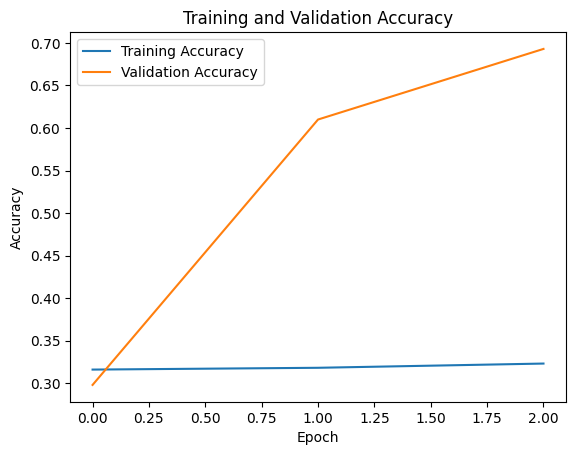

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

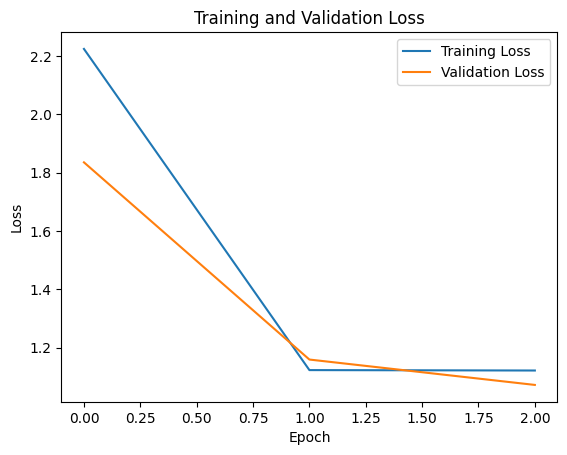

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#Model evaluation after training
loss, metric = model.evaluate([X_test, att_masks_test], Y_test, batch_size=16, verbose=0)
print(f"Loss after training: {loss:.4f}, Accuracy after training: {metric:.2%}")
print(f"Loss after training: {loss:.4f}, Accuracy after training: {metric:.4f}")
print(f"Loss after training: {loss:.4f}, Accuracy after training: {metric}")

Loss after training: 1.0727, Accuracy after training: 69.30%
Loss after training: 1.0727, Accuracy after training: 0.6930
Loss after training: 1.0727, Accuracy after training: 0.6930000185966492


In [ ]:
#Test Accuracy
loss, accuracy = model.evaluate([X_test, att_masks_test], Y_test)
print(f'Test accuracy: {accuracy * 100:.2f}%')
print(f'Test accuracy: {accuracy:.4f}%')
print(f'Test accuracy: {accuracy:}%')

63/63 [==============================] - 7s 69ms/step - loss: 1.0727 - accuracy: 0.6930
Test accuracy: 69.30%
Test accuracy: 0.6930%
Test accuracy: 0.6930000185966492%


In [ ]:
#Prediction
predictions_BERT = model.predict([X_test, att_masks_test])
test_prediction_BERT = pd.DataFrame()
test_prediction_BERT['Tweets'] = df2['Tweets']

63/63 [==============================] - 7s 67ms/step


In [ ]:
print(predictions_BERT)

TFSequenceClassifierOutput(loss=None, logits=array([[0.9927299 , 1.1228182 , 1.0513552 ],
       [0.991848  , 1.1248547 , 1.0515497 ],
       [0.99360776, 1.1207538 , 1.0517001 ],
       ...,
       [1.0019718 , 1.1044873 , 1.055692  ],
       [0.9978455 , 1.1124917 , 1.0538542 ],
       [0.998873  , 1.1124585 , 1.0542957 ]], dtype=float32), hidden_states=None, attentions=None)


In [ ]:
import numpy as np

# Assuming predictions_BERT is the TFSequenceClassifierOutput object
logits = predictions_BERT.logits

# Determine the predicted class for each sample
predicted_classes = np.argmax(logits, axis=1)

# Print the predicted classes
print(predicted_classes)

[1 1 1 ... 1 1 1]


In [ ]:
test_prediction_BERT['Classes'] = predicted_classes

In [ ]:
labels = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']
sentiment = [labels[idx] for idx in np.argmax(logits, axis=1)]
print(sentiment)

['POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'PO

In [ ]:
test_prediction_BERT['Sentiment'] = sentiment

In [ ]:
test_prediction_BERT

,Tweets,Classes,Sentiment
0,new post pocketimes youtube abang,1,POSITIVE
1,merdeka motherfuckers,1,POSITIVE
2,waiting bunga api kalau ada hahahah,1,POSITIVE
3,random pics places kl took using ig filters se...,1,POSITIVE
4,kim pangon malaysia try new players chiangmai,1,POSITIVE
...,...,...,...
1995,geng sila hadirkan diri padananpembelian full ...,1,POSITIVE
1996,terlalu top bosses senior managers berpeluang ...,1,POSITIVE
1997,geng hadirkan diri jika masuk market korang na...,1,POSITIVE
1998,berani duludulu bawa masuk coin tu jekredit twt,1,POSITIVE


In [ ]:
#Change the name of the output file
test_prediction_BERT.to_csv(r"69.30%16August2024_BERT_TestPart2_test_prediction(mBERT adam 16 2e-5 epoch 3).csv")

In [ ]:
import pandas as pd

value_counts = test_prediction_BERT['Sentiment'].value_counts()

print(value_counts)

Sentiment
POSITIVE    2000
Name: count, dtype: int64


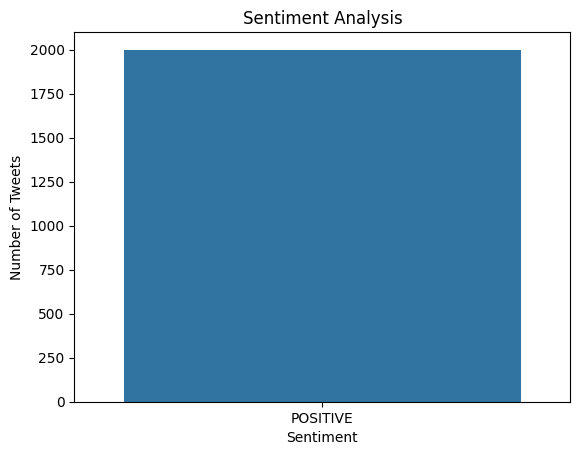

In [ ]:
#create bar graph
import matplotlib.pyplot as plt
import seaborn as sns

# create a barplot
sns.countplot(x='Sentiment', data= test_prediction_BERT)

# set the title
plt.title('Sentiment Analysis')

# set the x and y label
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')

# show the plot
plt.show()

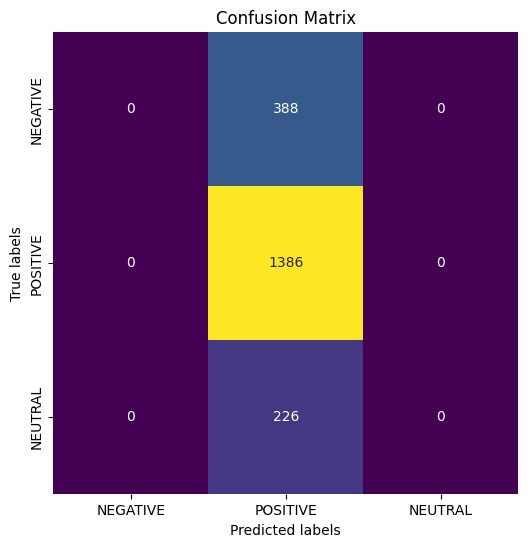

In [ ]:
#Confusion Matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming predictions_BERT is the TFSequenceClassifierOutput object
logits = predictions_BERT.logits

# Define your class labels
labels = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']

# Determine the predicted class for each sample and map to class names
predicted_classes = np.argmax(logits, axis=1)
predicted_sentiment = [labels[idx] for idx in predicted_classes]

# Assuming Y_test contains your actual labels
# If Y_test is in one-hot encoded format, convert it to class indices
Y_test_single = np.argmax(Y_test, axis=1) if len(Y_test.shape) > 1 else Y_test
true_sentiment = [labels[idx] for idx in Y_test_single]

# Calculate confusion matrix
conf_matrix = confusion_matrix(true_sentiment, predicted_sentiment, labels=labels)

# Display confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, cmap='viridis', fmt='d', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Classification Report
import numpy as np
from sklearn.metrics import classification_report

# Assuming predictions_BERT is the TFSequenceClassifierOutput object
logits = predictions_BERT.logits

# Define the class labels
labels = ['NEGATIVE', 'POSITIVE', 'NEUTRAL']

# Determine the predicted class for each sample
predicted_classes = np.argmax(logits, axis=1)

# Map predicted class indices to class names
sentiment = [labels[idx] for idx in predicted_classes]

# Convert one-hot encoded true labels back to categorical labels
true_labels = np.argmax(Y_test, axis=1)

# Generate the classification report with class names
report = classification_report(true_labels, predicted_classes, target_names=labels)
print(report)

# Print the predicted sentiments
print(sentiment)


              precision    recall  f1-score   support

    NEGATIVE       0.00      0.00      0.00       388
    POSITIVE       0.69      1.00      0.82      1386
     NEUTRAL       0.00      0.00      0.00       226

    accuracy                           0.69      2000
   macro avg       0.23      0.33      0.27      2000
weighted avg       0.48      0.69      0.57      2000

['POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSITIVE', 'POSIT

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[1 1 1 ... 1 1 1]
Shape of logits: (2000, 3)
Shape of predicted_probabilities: (2000, 3)
Shape of Y_test: (2000, 3)


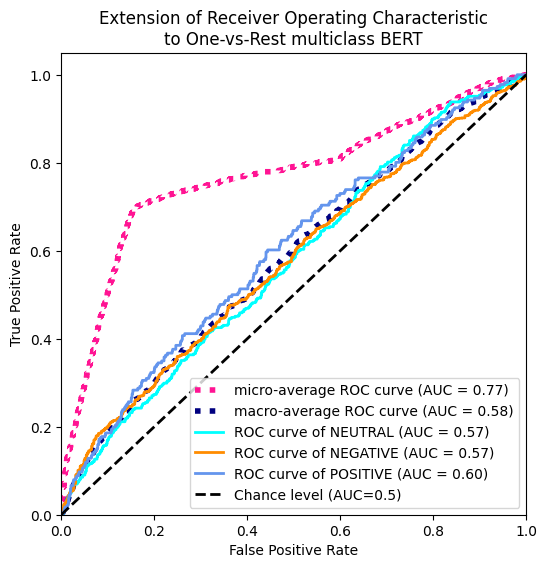

In [ ]:
#AUC-ROC
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

# Assuming predictions_BERT is the TFSequenceClassifierOutput object
logits = predictions_BERT.logits

# Determine the predicted class for each sample
predicted_classes = np.argmax(logits, axis=1)

# Print the predicted classes
print(predicted_classes)

# Convert logits to TensorFlow tensor
logits_tensor = tf.constant(logits, dtype=tf.float32)

# Apply softmax to get predicted probabilities
predicted_probabilities = tf.nn.softmax(logits_tensor, axis=-1).numpy()

# Example Y_test using one-hot encoded labels
Y_test = pd.get_dummies(df2['Sentiment (Manual)']).values

# Check if the shapes match
print(f"Shape of logits: {logits.shape}")
print(f"Shape of predicted_probabilities: {predicted_probabilities.shape}")
print(f"Shape of Y_test: {Y_test.shape}")

# Calculate ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = logits.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate microaverage ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted_probabilities.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Calculate macroaverage ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Class labels
labels = df2['Sentiment (Manual)'].unique()  # Replace with your actual class labels

# Plot ROC curves
fig, ax = plt.subplots(figsize=(6, 6))

# Plot microaverage ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot macroaverage ROC curve
plt.plot(fpr["macro"], tpr["macro"],
         label=f'macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})',
         color='navy', linestyle=':', linewidth=4)

# Plot ROC curves for each class
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of {labels[i]} (AUC = {roc_auc[i]:.2f})')

# Plot random classifier (chance level)
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=2, label='Chance level (AUC=0.5)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Extension of Receiver Operating Characteristic\nto One-vs-Rest multiclass BERT')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# Save the model in the TensorFlow SavedModel format
model.save('bert_model_16aug2024_adam_16_2e_5_epoch_3_mBERT', save_format='tf')

# Zip the saved model directory
!zip -r bert_model_16aug2024_adam_16_2e_5_epoch_3_mBERT.zip bert_model_16aug2024_adam_16_2e_5_epoch_3_mBERT

In [ ]:
# Save the model in the H5 format
#Change the name of the model
model.save_weights('bert_model_16aug2024_adam_16_2e_5_epoch_3_mBERT', save_format='h5')

# Zip the saved model directory
!zip -r bert_model_16aug2024_adam_16_2e_5_epoch_3_mBERT.zip bert_model_16aug2024_adam_16_2e_5_epoch_3_mBERT


In [ ]:
# Download the zipped model
from google.colab import files
files.download('bert_model_16aug2024_adam_16_2e_5_epoch_3_mBERT.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>